In [ ]:
import pandas as pd
import numpy as np
from dv01_calc import calculate_dv01_metrics

def backtest_spread_strategy(df, pred_col="prediction", open_etf_col="open_etf", close_etf_col="close_etf",
                             open_fut_col="open_fut", close_fut_col="close_fut",
                             initial_capital=10000000, margin_rate=0.1,
                             tick_etf=0.001, tick_fut=0.005):
    """
    基于预测价差方向的ETF-期货对冲套利策略回测。

    参数：
    - df : 包含ETF和期货行情及预测信号的数据（按日期顺序排序的DataFrame）
    - pred_col : 预测价差方向的列名，正值表示预期价差上行，负值表示预期价差下行
    - open_etf_col, open_fut_col : 每日开盘价列名（用于执行调仓交易价）
    - close_etf_col, close_fut_col : 每日收盘价列名（用于回测结束时平仓或计算最终收益）
    - initial_capital : 初始资金（元）
    - margin_rate : 期货保证金率（默认0.1，即10%）
    - tick_etf, tick_fut : ETF和期货的最小价格波动单位

    策略逻辑：
    - 若前一日预测信号为正，则当日开盘建仓：用约90%资金买入ETF，多头头寸；同时按等额资金卖出期货空头。
    - 若前一日预测信号为负或零，则当日开盘清仓：如有持仓则平掉多头ETF和空头期货头寸；若本来空仓则保持空仓。
    - 持仓期间每天计算持仓盈亏，允许连续持有多日直到出现平仓信号。
    - 考虑交易冲击成本：ETF交易价劣于市价3个tick，期货交易价劣于市价1个tick（双边各计，开平仓各一次）。
    
    返回：
    - result_df : 回测结果的DataFrame，每日记录包含日期、持仓状态、交易操作、账户权益等信息。
    - metrics : 策略绩效指标字典，包括年化收益率、最大回撤、Sharpe比率、Calmar比率和胜率等。
    """
    df = df.copy().reset_index(drop=True)  # 复制一份数据，确保按顺序索引
    # 初始化参数和状态变量
    capital = initial_capital      # 当前账户总资产（权益），初始为总资金
    cash = initial_capital         # 账户中的现金余额（未投入部分），初始等于总资金
    holding = False               # 持仓状态标志（False=空仓，True=持有套利仓位）
    n_etf_shares = 0              # 当前持有的ETF份额数
    n_fut_contracts = 0           # 当前持有的期货合约手数
    entry_price_etf = 0.0         # 最近一次开仓时ETF开盘价
    entry_price_fut = 0.0         # 最近一次开仓时期货开盘价

    # 用于记录每日回测结果
    records = []  # 每日记录的列表，将转换为DataFrame
    
    for i in range(len(df)):
        date = df.loc[i, 'date']  # 当前日期
        # 提取当日开盘价（用于交易执行）和收盘价（可能用于最后平仓）
        open_etf = df.loc[i, open_etf_col]
        open_fut = df.loc[i, open_fut_col]
        close_etf = df.loc[i, close_etf_col] if close_etf_col in df.columns else open_etf
        close_fut = df.loc[i, close_fut_col] if close_fut_col in df.columns else open_fut

        # 默认当日不发生交易
        trade_action = 0  # 1=开仓, -1=平仓, 0=无操作
        # 策略在每日开盘根据前一日预测信号决定操作，因此跳过第一天无法交易
        if i > 0:
            prev_pred = df.loc[i-1, pred_col]  # 前一天的预测值
        else:
            prev_pred = 0  # 无前日预测信号，视作无交易信号

        # **策略决策：根据前一日信号在今日开盘执行调仓**
        if prev_pred > 0 and not holding:
            # 前日预测价差将上行，且当前空仓 -> 今日开盘建立套利仓位
            # 计算可买入ETF手数和可卖出期货手数（按90%资金规模）
            available_funds = capital * 0.90  # 可用于建立仓位的资金（约90%初始资金）
            # 计算ETF买入份额：取整到最小交易单位1手=100份
            etf_lot_size = 100
            # 按开盘价计算最大可买入份额数（整手）
            max_etf_shares = np.floor(available_funds / (open_etf * etf_lot_size)) * etf_lot_size
            max_etf_shares = int(max_etf_shares)
            # 计算期货卖出手数：按可用资金等值的合约市值计算，取整手数
            # 假设每手期货合约名义价值 = 开盘价 * 10000元（国债期货合约面值100万，报价为百元价，因此乘以10000）

            max_fut_contracts = int(np.floor(available_funds / (open_fut * 10000)))
            

            if max_etf_shares > 0 and max_fut_contracts > 0:
                # 决定开仓手数（ETF和期货按等价值对冲，此处可进一步根据DV01等调整比例）
                n_etf_shares = max_etf_shares
                n_fut_contracts = max_fut_contracts
                # 记录开仓基准价格
                entry_price_etf = open_etf
                entry_price_fut = open_fut

                # 计算交易成本（滑点）并更新现金：
                # ETF买入成本：按市价买入n_etf_shares份额，需要支付资金 = open_etf * n_etf_shares
                # 滑点损失：买入ETF按高于市价3个tick成交，多支出 slip_etf_cost 元
                base_etf_cost = n_etf_shares * open_etf
                slip_etf_cost = n_etf_shares * tick_etf * 3
                # 期货卖出无直接资金支出，但滑点损失：按低于市价1个tick成交，相当于损失 slip_fut_cost 元
                slip_fut_cost = n_fut_contracts * tick_fut * 10000  # 每手期货1个tick价值= tick_fut*10000 元
                # 扣除买ETF花费和所有滑点成本
                cash -= (base_etf_cost + slip_etf_cost + slip_fut_cost)
                # 更新持仓状态为已持仓
                holding = True
                trade_action = 1  # 标记本日执行了开仓操作
                # 计算开仓后账户权益capital：
                # 持有ETF价值 + 剩余现金 + （期货头寸初始未实现盈亏）
                # 此时ETF市值 = n_etf_shares * open_etf；期货未实现盈亏=0（按开仓价计），现金已扣除成本
                etf_value = n_etf_shares * open_etf
                capital = cash + etf_value
            # 若计算得到的最大仓位为0（资金不足以开仓），则保持空仓，不执行交易
        elif prev_pred <= 0 and holding:
            # 前日预测价差将下行或无信号，且当前有持仓 -> 今日开盘平仓，清空头寸
            # 按当日开盘价计算平仓收益：
            exit_price_etf = open_etf
            exit_price_fut = open_fut
            # 计算持仓期间未实现盈亏：
            # ETF部分盈亏 = (卖出价 - 买入价) * 持有份额
            pnl_etf = (exit_price_etf - entry_price_etf) * n_etf_shares
            # 期货部分盈亏（空头）：= (卖出价 - 买入价) * 合约数量 * 10000 
            # 注意：entry_price_fut是卖出建仓价，exit_price_fut是买入平仓价
            pnl_fut = (entry_price_fut - exit_price_fut) * n_fut_contracts * 10000
            total_pnl = pnl_etf + pnl_fut
            # 平仓交易更新现金：
            # 卖出ETF回笼资金 = exit_price_etf * n_etf_shares
            cash += exit_price_etf * n_etf_shares
            # 加上期货部分盈亏（亏损则扣除）
            cash += pnl_fut
            # 计算滑点成本：ETF卖出滑点3tick，期货买入滑点1tick
            slip_etf_cost = n_etf_shares * tick_etf * 3
            slip_fut_cost = n_fut_contracts * tick_fut * 10000
            cash -= (slip_etf_cost + slip_fut_cost)
            # 更新账户总权益
            capital = cash
            # 记录交易收益用于胜率统计
            realized_pnl = total_pnl - (slip_etf_cost + slip_fut_cost)
            # 将本次交易结果加入统计列表（胜率计算）
            # （可以在函数外部维护一个列表收集交易盈亏，这里略去全局列表，直接用本地变量）
            trade_action = -1  # 标记本日平仓
            holding = False
            n_etf_shares = 0
            n_fut_contracts = 0
        # 如果没有触发交易，则保持前一日状态（要么继续持仓，要么继续空仓）
        
        # **每日权益与持仓记录：**
        if holding:
            # 若当前持有仓位，计算当日开盘时点账户权益（标记仓位市场价值变动）
            # ETF部分市值 = n_etf_shares * open_etf
            etf_value = n_etf_shares * open_etf
            # 期货部分未实现盈亏 = (建仓价 - 当前价) * 合约数 * 10000（空头头寸，如果期货下跌该项为正收益）
            fut_unreal_pnl = (entry_price_fut - open_fut) * n_fut_contracts * 10000
            current_equity = cash + etf_value + fut_unreal_pnl
            position_flag = 1
        else:
            # 空仓状态，当前权益即为现金余额
            current_equity = cash
            position_flag = 0

        # 记录当日结果
        cum_return = (current_equity / initial_capital) - 1  # 累计收益率（相对于初始资金）
        records.append({
            "date": date,
            "position": position_flag,
            "trade": trade_action,
            "equity": current_equity,
            "cum_return": cum_return
        })

    # 回测循环结束。如果最后仍有持仓未平仓，这里根据需要可选择在最后收盘价平仓（本策略已在收到信号时平仓，因此一般无需处理）。
    # （如需强制平仓，可参考上述逻辑在最后一天close_etf/close_fut处计算盈亏并更新cash和capital。）

    # 将记录列表转为DataFrame
    result_df = pd.DataFrame(records)
    # 计算每日策略收益率（权益曲线的日度变化率）
    result_df["strategy_ret"] = result_df["equity"].pct_change().fillna(0)

    # **绩效指标计算：**
    # 年化收益率（annual return）
    total_return = (result_df["equity"].iloc[-1] / initial_capital) - 1
    # 以回测交易日数量折算年化（假设一年约252个交易日）
    trade_days = result_df.shape[0]
    annual_return = (1 + total_return) ** (252 / trade_days) - 1 if trade_days > 0 else 0.0
    # 最大回撤（max drawdown）：权益曲线从峰值到谷值的最大跌幅
    cumulative_max = result_df["equity"].cummax()
    drawdown = (result_df["equity"] - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()  # 取最小值（负值）
    max_drawdown_pct = abs(max_drawdown)  # 取正值表示回撤率
    # Sharpe比率：日收益率的均值/标准差 * sqrt(252)
    daily_returns = result_df["strategy_ret"]
    if daily_returns.std() != 0:
        sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    else:
        sharpe_ratio = 0.0
    # Calmar比率：年化收益率 / 最大回撤
    calmar_ratio = annual_return / max_drawdown_pct if max_drawdown_pct != 0 else np.nan
    # 单次交易胜率：统计每笔完整交易收益为正的比例
    # 从result_df交易记录推断交易盈亏：可以根据trade标记1开仓，-1平仓配对计算每笔盈亏
    wins = 0
    losses = 0
    position = 0
    entry_equity = 0.0
    for idx, row in result_df.iterrows():
        if row["trade"] == 1:
            # 开仓时记录权益基准
            position = 1
            entry_equity = row["equity"]
        elif row["trade"] == -1 and position == 1:
            # 平仓时计算该笔交易盈亏
            profit = row["equity"] - entry_equity
            if profit > 0:
                wins += 1
            else:
                losses += 1
            position = 0
    total_trades = wins + losses
    win_rate = wins / total_trades if total_trades > 0 else np.nan

    # 打印策略关键指标
    print(f"年化收益率: {annual_return*100:.2f}%")
    print(f"最大回撤: {max_drawdown_pct*100:.2f}%")
    print(f"Sharpe比: {sharpe_ratio:.2f}")
    print(f"Calmar比: {calmar_ratio:.2f}")
    print(f"胜率: {win_rate*100:.2f}% (交易次数: {total_trades})")

    # 将指标汇总为字典方便返回或进一步使用
    metrics = {
        "annual_return": annual_return,
        "max_drawdown": max_drawdown_pct,
        "sharpe_ratio": sharpe_ratio,
        "calmar_ratio": calmar_ratio,
        "win_rate": win_rate,
        "total_trades": total_trades
    }
    return result_df, metrics


In [6]:
# modified backtest function to include DV01 metrics

"""
backtest.py
===============

此脚本实现了一个面向富国中债 7–10 年政金债 ETF 与 30 年国债期货（T2509）
价差策略的回测框架，包含以下改进特性：

1. **DV01 对冲比例嵌入**：调用 ``dv01_calc.calculate_dv01_metrics`` 按日计算
   ETF 的 DV01 和期货的 DV01，并据此生成 ``hedge_ratio``，表示每份 ETF
   需要对冲的期货合约手数。开仓时根据该比例动态确定 ETF 与期货持仓量，
   使组合对利率变化保持中性【263†L1-L8】。

2. **信号对齐与滑动持仓**：将预测列（如 5 日预测）向前平移相应期限，
   获得 ``pred_signal_today``。当 ``pred_signal_today`` 为正时建立或持有
   现券多头/期货空头仓位；当信号非正或触发止盈/止损条件时平仓【263†L1-L8】。

3. **止盈止损机制**：持仓期间动态计算浮动收益率，默认当累计收益率达到
   ±0.5% 时强制平仓锁定结果。用户可调整 ``stop_gain``、``stop_loss``
   参数控制阈值。

4. **交易盈亏记录**：在平仓时将每笔交易的盈亏率保存到 ``realized_pnls``
   列表，便于后续统计胜率和盈亏分布。

5. **完整绩效指标**：回测结束后计算年化收益率、最大回撤、Sharpe 比率、
   Calmar 比率和胜率等指标。

使用方式：

```
import pandas as pd
from backtest import backtest_spread_strategy

# 读取含有日期、开盘价、收盘价、预测列的数据
data = pd.read_csv("your_merged_data.csv")

# 假设预测列为 lars_bayes_pred_5d 表示预测 5 日后的价差变化
result_df, metrics, realized_pnls = backtest_spread_strategy(
    df=data,
    pred_col="lars_bayes_pred_5d",
    open_etf_col="open_etf",
    open_fut_col="open_fut",
    close_etf_col="close_etf",
    close_fut_col="close_fut",
    initial_capital=10000000,
    margin_rate=0.1,
    tick_etf=0.001,
    tick_fut=0.005,
    etf_duration=7.5,
    conversion_factor=0.925,
    stop_gain=0.005,
    stop_loss=0.005
)

# 查看回测结果
print(metrics)
print(result_df.tail())
```
"""

import math
from typing import Tuple, List

import numpy as np
import pandas as pd

from dv01_calc import calculate_dv01_metrics


def backtest_spread_strategy(
    df: pd.DataFrame,
    pred_col: str = "lars_bayes_pred_5d",
    open_etf_col: str = "open_etf",
    open_fut_col: str = "open_fut",
    close_etf_col: str = "close_etf",
    close_fut_col: str = "close_fut",
    initial_capital: float = 10_000_000,
    margin_rate: float = 0.1,
    tick_etf: float = 0.001,
    tick_fut: float = 0.005,
    etf_duration: float = 7.5,
    conversion_factor: float = 0.925,
    stop_gain: float = 0.005,
    stop_loss: float = 0.005,
) -> Tuple[pd.DataFrame, dict, List[float]]:
    """基于预测信号和 DV01 对冲的 ETF–期货价差策略回测。

    参数说明：
    - df: 包含行情数据和预测列的数据，必须按日期升序排列，并包含如下列：
      ``date``、``open_etf_col``、``open_fut_col``、``close_etf_col``、``close_fut_col``、以及预测列 ``pred_col``。
    - pred_col: 预测列名称，假定预测的是未来 N 日后的价差变化。
    - open_etf_col/open_fut_col: ETF 和期货的开盘价列名，用于执行交易；
    - close_etf_col/close_fut_col: ETF 和期货的收盘价列名，用于计算 DV01 及评价持仓；
    - initial_capital: 初始账户资金；
    - margin_rate: 期货合约保证金率；
    - tick_etf/tick_fut: ETF 和期货最小跳动单位，用于估算滑点成本；
    - etf_duration: ETF 久期，用于 DV01 计算；
    - conversion_factor: 期货 CTD 债券的转换因子；
    - stop_gain/stop_loss: 止盈止损阈值，表示相对开仓权益的收益率。

    返回值：
    - result_df: 包含每日持仓、交易标记、账户权益等信息的 DataFrame。
    - metrics: 字典形式的绩效指标，包括年化收益率、最大回撤、Sharpe 比率、Calmar 比率和胜率。
    - realized_pnls: 平仓交易的盈亏比列表，用于进一步分析。
    """
    # 复制一份数据并按日期排序
    df = df.copy().reset_index(drop=True)
    if "date" not in df.columns:
        raise ValueError("DataFrame must contain a 'date' column with trading dates.")
    df.sort_values("date", inplace=True)

    # === 1. 按日计算 DV01 对冲比例并合并 ===
    # 使用收盘价来计算 DV01 指标，调用 utils.dv01_calc.calculate_dv01_metrics
    dv01_df = calculate_dv01_metrics(
        df[["date", close_etf_col, close_fut_col]].rename(columns={
            close_etf_col: "close_etf",
            close_fut_col: "close_fut",
        }),
        etf_duration=etf_duration,
        ctd_dv01=0.042,
        conversion_factor=conversion_factor,
    )
    # 合并 hedge_ratio 到主表
    df = df.merge(dv01_df[["date", "hedge_ratio"]], on="date", how="left")

    # === 2. 对齐预测信号：将 pred_col 向前平移 N 行作为当日交易信号 ===
    # 通过计算预测列的有效期数（例如列名以 '5d' 结尾表示预测5日后的变化）
    # 如果无法解析，默认不移位，即预测即时使用
    pred_shift = 0
    # 尝试解析末尾数字
    import re
    match = re.search(r"(\d+)d$", pred_col)
    if match:
        pred_shift = int(match.group(1))
    # 创建用于决策的信号列
    signal_col = "_signal_today"
    if pred_shift > 0:
        df[signal_col] = df[pred_col].shift(-pred_shift)
    else:
        df[signal_col] = df[pred_col]

    # === 3. 初始化账户和交易状态 ===
    cash: float = initial_capital  # 账户现金
    capital: float = initial_capital  # 账户总权益
    holding: bool = False  # 是否持仓
    n_etf: float = 0.0  # 当前持有 ETF 份额数
    n_fut: int = 0  # 当前持有期货手数
    entry_equity: float = 0.0  # 开仓时的账户权益
    entry_etf_price: float = 0.0  # 开仓时 ETF 价格
    entry_fut_price: float = 0.0  # 开仓时期货价格
    realized_pnls: List[float] = []  # 每笔交易盈亏率

    # 用于记录每日结果
    records: List[dict] = []

    # === 4. 遍历交易日 ===
    for idx in range(len(df)):
        row = df.loc[idx]
        date = row["date"]
        open_etf = row[open_etf_col]
        open_fut = row[open_fut_col]
        close_etf = row[close_etf_col]
        close_fut = row[close_fut_col]
        hedge_ratio = row["hedge_ratio"] if not pd.isna(row["hedge_ratio"]) else 0.0
        signal_today = row[signal_col]

        trade_action = 0  # 1=开仓，-1=平仓，0=无交易

        # === 4.1 如果已经持仓，先判断是否止盈止损或信号翻转 ===
        if holding:
            # 按开盘价评估当前权益
            etf_value_open = n_etf * open_etf
            fut_pnl_open = (entry_fut_price - open_fut) * n_fut * 10000  # 期货空头盈亏
            current_equity_open = cash + etf_value_open + fut_pnl_open
            # 相对开仓权益的收益率
            pnl_rate = (current_equity_open - entry_equity) / entry_equity if entry_equity != 0 else 0.0
            # 止盈 / 止损 / 信号翻转
            if pnl_rate >= stop_gain or pnl_rate <= -stop_loss or not (signal_today > 0):
                # 平仓：以开盘价退出持仓
                cash = current_equity_open
                # 记录交易盈亏率
                realized_pnls.append(pnl_rate)
                # 重置持仓状态
                holding = False
                n_etf = 0.0
                n_fut = 0
                trade_action = -1
                # capital 更新为现金
                capital = cash

        # === 4.2 若空仓且信号为正，则尝试开仓 ===
        if not holding and (signal_today is not None and signal_today > 0):
            # 预留 90% 的资金用于开仓
            available_funds = capital * 0.90
            if open_etf <= 0 or hedge_ratio <= 0:
                # 价格或对冲比例非法，跳过
                pass
            else:
                # 初步按照资金确定 ETF 份额数（忽略期货保证金）
                max_etf = math.floor(available_funds / open_etf)
                # 根据 DV01 对冲比例计算期货手数（向最接近整数取整，至少为 1 手）
                n_fut = max(1, int(round(max_etf * hedge_ratio)))
                # 根据期货数量反推所需 ETF 份额数（即 n_etf = n_fut / hedge_ratio）
                # 使用四舍五入取整
                n_etf = n_fut / hedge_ratio
                # 保证 ETF 份额为整数
                n_etf = math.floor(n_etf)
                # 计算期货保证金
                margin_required = n_fut * margin_rate * open_fut * 10000
                # 计算ETF买入金额
                etf_cost = n_etf * open_etf
                # 总资金需求
                total_required = margin_required + etf_cost
                if total_required > available_funds and total_required > 0:
                    # 按资金比例缩减仓位
                    scale = available_funds / total_required
                    n_etf = math.floor(n_etf * scale)
                    n_fut = max(1, int(round(n_etf * hedge_ratio)))
                    margin_required = n_fut * margin_rate * open_fut * 10000
                    etf_cost = n_etf * open_etf
                    total_required = margin_required + etf_cost
                    # 若仍超出资金则跳过开仓
                    if total_required > available_funds:
                        n_etf = 0
                        n_fut = 0
                if n_etf > 0 and n_fut > 0:
                    # 计算交易成本（滑点）：ETF 买入按高 3 tick 成交，期货卖出按低 1 tick 成交
                    slip_etf_cost = n_etf * tick_etf * 3
                    slip_fut_cost = n_fut * tick_fut * 10000
                    # 扣除 ETF 买入成本、期货滑点成本
                    cash -= (etf_cost + slip_etf_cost + slip_fut_cost)
                    # 更新持仓状态和记录开仓时的基准数据
                    holding = True
                    trade_action = 1
                    entry_equity = cash + n_etf * open_etf  # 不计期货市值
                    entry_etf_price = open_etf
                    entry_fut_price = open_fut
                    capital = entry_equity

        # === 4.3 记录每日权益和仓位 ===
        if holding:
            # 持仓状态下，按当日开盘价计算当前权益（标记期货盈亏）
            etf_value_open = n_etf * open_etf
            fut_pnl_open = (entry_fut_price - open_fut) * n_fut * 10000
            current_equity = cash + etf_value_open + fut_pnl_open
            position_flag = 1
        else:
            current_equity = cash
            position_flag = 0
        # 记录数据
        cum_return = (current_equity / initial_capital) - 1
        records.append({
            "date": date,
            "position": position_flag,
            "trade": trade_action,
            "equity": current_equity,
            "cum_return": cum_return
        })

    # === 5. 构建结果 DataFrame ===
    result_df = pd.DataFrame(records)
    # 日收益率
    result_df["strategy_ret"] = result_df["equity"].pct_change().fillna(0)

    # === 6. 绩效指标计算 ===
    trade_days = len(result_df)
    final_equity = result_df["equity"].iloc[-1]
    total_return = (final_equity / initial_capital) - 1
    annual_return = (1 + total_return) ** (252 / trade_days) - 1 if trade_days > 0 else 0.0
    # 最大回撤
    cumulative_max = result_df["equity"].cummax()
    drawdown = result_df["equity"] / cumulative_max - 1
    max_drawdown = abs(drawdown.min()) if not drawdown.empty else 0.0
    # Sharpe 比率
    daily_returns = result_df["strategy_ret"]
    if daily_returns.std() != 0:
        sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    else:
        sharpe_ratio = 0.0
    # Calmar 比率
    calmar_ratio = annual_return / max_drawdown if max_drawdown > 1e-8 else float('nan')
    # 胜率
    win_trades = sum(1 for pnl in realized_pnls if pnl > 0)
    total_trades = len(realized_pnls)
    win_rate = win_trades / total_trades if total_trades > 0 else float('nan')
    metrics = {
        "annual_return": annual_return,
        "max_drawdown": max_drawdown,
        "sharpe_ratio": sharpe_ratio,
        "calmar_ratio": calmar_ratio,
        "win_rate": win_rate,
        "total_trades": total_trades,
    }
    return result_df, metrics, realized_pnls

## 修改版本回测，加入基础仓位和动态加仓 

In [16]:
# modified backtest function to include DV01 metrics

"""
backtest.py
===============

此脚本实现了一个面向富国中债 7–10 年政金债 ETF 与 30 年国债期货（T2509）
价差策略的回测框架，包含以下改进特性：

1. **DV01 对冲比例嵌入**：调用 ``dv01_calc.calculate_dv01_metrics`` 按日计算
   ETF 的 DV01 和期货的 DV01，并据此生成 ``hedge_ratio``，表示每份 ETF
   需要对冲的期货合约手数。开仓时根据该比例动态确定 ETF 与期货持仓量，
   使组合对利率变化保持中性【263†L1-L8】。

2. **信号对齐与滑动持仓**：将预测列（如 5 日预测）向前平移相应期限，
   获得 ``pred_signal_today``。当 ``pred_signal_today`` 为正时建立或持有
   现券多头/期货空头仓位；当信号非正或触发止盈/止损条件时平仓【263†L1-L8】。

3. **止盈止损机制**：持仓期间动态计算浮动收益率，默认当累计收益率达到
   ±0.5% 时强制平仓锁定结果。用户可调整 ``stop_gain``、``stop_loss``
   参数控制阈值。

4. **交易盈亏记录**：在平仓时将每笔交易的盈亏率保存到 ``realized_pnls``
   列表，便于后续统计胜率和盈亏分布。

5. **完整绩效指标**：回测结束后计算年化收益率、最大回撤、Sharpe 比率、
   Calmar 比率和胜率等指标。

使用方式：

```
import pandas as pd
from backtest import backtest_spread_strategy

# 读取含有日期、开盘价、收盘价、预测列的数据
data = pd.read_csv("your_merged_data.csv")

# 假设预测列为 lars_bayes_pred_5d 表示预测 5 日后的价差变化
result_df, metrics, realized_pnls = backtest_spread_strategy(
    df=data,
    pred_col="lars_bayes_pred_5d",
    open_etf_col="open_etf",
    open_fut_col="open_fut",
    close_etf_col="close_etf",
    close_fut_col="close_fut",
    initial_capital=10000000,
    margin_rate=0.1,
    tick_etf=0.001,
    tick_fut=0.005,
    etf_duration=7.5,
    conversion_factor=0.925,
    stop_gain=0.005,
    stop_loss=0.005
)

# 查看回测结果
print(metrics)
print(result_df.tail())
```
"""

import math
from typing import Tuple, List

import numpy as np
import pandas as pd

from dv01_calc import calculate_dv01_metrics


def backtest_spread_strategy(
    df: pd.DataFrame,
    pred_col: str = "lars_bayes_pred_5d",
    open_etf_col: str = "open_etf",
    open_fut_col: str = "open_fut",
    close_etf_col: str = "close_etf",
    close_fut_col: str = "close_fut",
    initial_capital: float = 10_000_000,
    margin_rate: float = 0.1,
    tick_etf: float = 0.001,
    tick_fut: float = 0.005,
    etf_duration: float = 7.5,
    conversion_factor: float = 0.925,
    stop_gain: float = 0.005,
    stop_loss: float = 0.005,
) -> Tuple[pd.DataFrame, dict, List[float]]:
    """基于预测信号和 DV01 对冲的 ETF–期货价差策略回测。

    参数说明：
    - df: 包含行情数据和预测列的数据，必须按日期升序排列，并包含如下列：
      ``date``、``open_etf_col``、``open_fut_col``、``close_etf_col``、``close_fut_col``、以及预测列 ``pred_col``。
    - pred_col: 预测列名称，假定预测的是未来 N 日后的价差变化。
    - open_etf_col/open_fut_col: ETF 和期货的开盘价列名，用于执行交易；
    - close_etf_col/close_fut_col: ETF 和期货的收盘价列名，用于计算 DV01 及评价持仓；
    - initial_capital: 初始账户资金；
    - margin_rate: 期货合约保证金率；
    - tick_etf/tick_fut: ETF 和期货最小跳动单位，用于估算滑点成本；
    - etf_duration: ETF 久期，用于 DV01 计算；
    - conversion_factor: 期货 CTD 债券的转换因子；
    - stop_gain/stop_loss: 止盈止损阈值，表示相对开仓权益的收益率。

    返回值：
    - result_df: 包含每日持仓、交易标记、账户权益等信息的 DataFrame。
    - metrics: 字典形式的绩效指标，包括年化收益率、最大回撤、Sharpe 比率、Calmar 比率和胜率。
    - realized_pnls: 平仓交易的盈亏比列表，用于进一步分析。
    """
    # 复制一份数据并按日期排序
    df = df.copy().reset_index(drop=True)
    if "date" not in df.columns:
        raise ValueError("DataFrame must contain a 'date' column with trading dates.")
    df.sort_values("date", inplace=True)

    # === 1. 按日计算 DV01 对冲比例并合并 ===
    # 使用收盘价来计算 DV01 指标，调用 utils.dv01_calc.calculate_dv01_metrics
    dv01_df = calculate_dv01_metrics(
        df[["date", close_etf_col, close_fut_col]].rename(columns={
            close_etf_col: "close_etf",
            close_fut_col: "close_fut",
        }),
        etf_duration=etf_duration,
        ctd_dv01=0.042,
        conversion_factor=conversion_factor,
    )
    # 合并 hedge_ratio 到主表
    df = df.merge(dv01_df[["date", "hedge_ratio"]], on="date", how="left")

    # === 2. 对齐预测信号：将 pred_col 向前平移 N 行作为当日交易信号 ===
    # 通过计算预测列的有效期数（例如列名以 '5d' 结尾表示预测5日后的变化）
    # 如果无法解析，默认不移位，即预测即时使用
    pred_shift = 0
    # 尝试解析末尾数字
    import re
    match = re.search(r"(\d+)d$", pred_col)
    if match:
        pred_shift = int(match.group(1))
    # 创建用于决策的信号列
    signal_col = "_signal_today"
    if pred_shift > 0:
        df[signal_col] = df[pred_col].shift(-pred_shift)
    else:
        df[signal_col] = df[pred_col]

    # === 3. 初始化账户和交易状态 ===
    base_built = False
    base_etf_units = 0
    base_fut_units = 0
    alpha_etf_units = 0
    alpha_fut_units = 0
    entry_equity_alpha = None

    cash: float = initial_capital  # 账户现金
    capital: float = initial_capital  # 账户总权益
    holding: bool = False  # 是否持仓
    n_etf: float = 0.0  # 当前持有 ETF 份额数
    n_fut: int = 0  # 当前持有期货手数
    entry_equity: float = 0.0  # 开仓时的账户权益
    entry_etf_price: float = 0.0  # 开仓时 ETF 价格
    entry_fut_price: float = 0.0  # 开仓时期货价格
    realized_pnls: List[float] = []  # 每笔交易盈亏率

    # 用于记录每日结果
    records: List[dict] = []

    # === 4. 遍历交易日 ===
    for idx in range(len(df)):
        row = df.loc[idx]
        date = row["date"]
        open_etf = row[open_etf_col]
        open_fut = row[open_fut_col]
        close_etf = row[close_etf_col]
        close_fut = row[close_fut_col]
        hedge_ratio = row["hedge_ratio"] if not pd.isna(row["hedge_ratio"]) else 0.0
        signal_today = row[signal_col]

        # === Alpha/Base 双仓逻辑 ===
        if not base_built and signal_today > 0 and hedge_ratio > 0 and open_etf > 0:
            base_etf_units = 1000
            base_fut_units = int(round(base_etf_units * hedge_ratio))
            base_built = True

        if signal_today < -0.3 and hedge_ratio > 0:
            if alpha_etf_units < 2 * base_etf_units:
                alpha_etf_units += 100
                alpha_fut_units += int(round(100 * hedge_ratio))
                entry_equity_alpha = cash + (base_etf_units + alpha_etf_units) * open_etf - (base_fut_units + alpha_fut_units) * open_fut * 10000

        if alpha_etf_units > 0 and entry_equity_alpha:
            total_value_now = cash + (base_etf_units + alpha_etf_units) * open_etf - (base_fut_units + alpha_fut_units) * open_fut * 10000
            alpha_pnl = total_value_now - entry_equity_alpha
            alpha_pnl_rate = alpha_pnl / entry_equity_alpha
            if alpha_pnl_rate >= stop_gain or alpha_pnl_rate <= -stop_loss:
                realized_pnls.append(alpha_pnl_rate)
                alpha_etf_units = 0
                alpha_fut_units = 0
                entry_equity_alpha = None
        date = row["date"]
        open_etf = row[open_etf_col]
        open_fut = row[open_fut_col]
        close_etf = row[close_etf_col]
        close_fut = row[close_fut_col]
        hedge_ratio = row["hedge_ratio"] if not pd.isna(row["hedge_ratio"]) else 0.0
        signal_today = row[signal_col]

        trade_action = 0  # 1=开仓，-1=平仓，0=无交易

        # === 4.1 如果已经持仓，先判断是否止盈止损或信号翻转 ===
        if holding:
            # 按开盘价评估当前权益
            etf_value_open = n_etf * open_etf
            fut_pnl_open = (entry_fut_price - open_fut) * n_fut * 10000  # 期货空头盈亏
            current_equity_open = cash + etf_value_open + fut_pnl_open
            # 相对开仓权益的收益率
            pnl_rate = (current_equity_open - entry_equity) / entry_equity if entry_equity != 0 else 0.0
            # 止盈 / 止损 / 信号翻转
            if pnl_rate >= stop_gain or pnl_rate <= -stop_loss or not (signal_today > 0):
                # 平仓：以开盘价退出持仓
                cash = current_equity_open
                # 记录交易盈亏率
                realized_pnls.append(pnl_rate)
                # 重置持仓状态
                holding = False
                n_etf = 0.0
                n_fut = 0
                trade_action = -1
                # capital 更新为现金
                capital = cash

        # === 4.2 若空仓且信号为正，则尝试开仓 ===
        if not holding and (signal_today is not None and signal_today > 0):
            # 预留 90% 的资金用于开仓
            available_funds = capital * 0.90
            if open_etf <= 0 or hedge_ratio <= 0:
                # 价格或对冲比例非法，跳过
                pass
            else:
                # 初步按照资金确定 ETF 份额数（忽略期货保证金）
                max_etf = math.floor(available_funds / open_etf)
                # 根据 DV01 对冲比例计算期货手数（向最接近整数取整，至少为 1 手）
                n_fut = max(1, int(round(max_etf * hedge_ratio)))
                # 根据期货数量反推所需 ETF 份额数（即 n_etf = n_fut / hedge_ratio）
                # 使用四舍五入取整
                n_etf = n_fut / hedge_ratio
                # 保证 ETF 份额为整数
                n_etf = math.floor(n_etf)
                # 计算期货保证金
                margin_required = n_fut * margin_rate * open_fut * 10000
                # 计算ETF买入金额
                etf_cost = n_etf * open_etf
                # 总资金需求
                total_required = margin_required + etf_cost
                if total_required > available_funds and total_required > 0:
                    # 按资金比例缩减仓位
                    scale = available_funds / total_required
                    n_etf = math.floor(n_etf * scale)
                    n_fut = max(1, int(round(n_etf * hedge_ratio)))
                    margin_required = n_fut * margin_rate * open_fut * 10000
                    etf_cost = n_etf * open_etf
                    total_required = margin_required + etf_cost
                    # 若仍超出资金则跳过开仓
                    if total_required > available_funds:
                        n_etf = 0
                        n_fut = 0
                if n_etf > 0 and n_fut > 0:
                    # 计算交易成本（滑点）：ETF 买入按高 3 tick 成交，期货卖出按低 1 tick 成交
                    slip_etf_cost = n_etf * tick_etf * 3
                    slip_fut_cost = n_fut * tick_fut * 10000
                    # 扣除 ETF 买入成本、期货滑点成本
                    cash -= (etf_cost + slip_etf_cost + slip_fut_cost)
                    # 更新持仓状态和记录开仓时的基准数据
                    holding = True
                    trade_action = 1
                    entry_equity = cash + n_etf * open_etf  # 不计期货市值
                    entry_etf_price = open_etf
                    entry_fut_price = open_fut
                    capital = entry_equity

        # === 4.3 记录每日权益和仓位 ===
        if holding:
            # 持仓状态下，按当日开盘价计算当前权益（标记期货盈亏）
            etf_value_open = n_etf * open_etf
            fut_pnl_open = (entry_fut_price - open_fut) * n_fut * 10000
            current_equity = cash + (base_etf_units + alpha_etf_units) * open_etf + (entry_fut_price - open_fut) * (base_fut_units + alpha_fut_units) * 10000
            position_flag = 1
        else:
            current_equity = cash
            position_flag = 0
        # 记录数据
        cum_return = (current_equity / initial_capital) - 1
        records.append({
            "date": date,
            "position": position_flag,
            "trade": trade_action,
            "equity": current_equity,
            "cum_return": cum_return
        })

    # === 5. 构建结果 DataFrame ===
    result_df = pd.DataFrame(records)
    # 日收益率
    result_df["strategy_ret"] = result_df["equity"].pct_change().fillna(0)

    # === 6. 绩效指标计算 ===
    trade_days = len(result_df)
    final_equity = result_df["equity"].iloc[-1]
    total_return = (final_equity / initial_capital) - 1
    annual_return = (1 + total_return) ** (252 / trade_days) - 1 if trade_days > 0 else 0.0
    # 最大回撤
    cumulative_max = result_df["equity"].cummax()
    drawdown = result_df["equity"] / cumulative_max - 1
    max_drawdown = abs(drawdown.min()) if not drawdown.empty else 0.0
    # Sharpe 比率
    daily_returns = result_df["strategy_ret"]
    if daily_returns.std() != 0:
        sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
    else:
        sharpe_ratio = 0.0
    # Calmar 比率
    calmar_ratio = annual_return / max_drawdown if max_drawdown > 1e-8 else float('nan')
    # 胜率
    win_trades = sum(1 for pnl in realized_pnls if pnl > 0)
    total_trades = len(realized_pnls)
    win_rate = win_trades / total_trades if total_trades > 0 else float('nan')
    metrics = {
        "annual_return": annual_return,
        "max_drawdown": max_drawdown,
        "sharpe_ratio": sharpe_ratio,
        "calmar_ratio": calmar_ratio,
        "win_rate": win_rate,
        "total_trades": total_trades,
    }
    return result_df, metrics, realized_pnls

In [18]:
# 🔧 可视化函数（新增）：收益折线图与 alpha 仓位图
import matplotlib.pyplot as plt

def plot_alpha_strategy(result_df):
    plt.figure(figsize=(12, 4))
    plt.plot(result_df["date"], result_df["equity"], label="Total Equity")
    plt.title("账户权益曲线")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 2))
    plt.plot(result_df["date"], result_df["alpha_etf_units"], label="Alpha ETF Units", color="darkred")
    plt.axhline(y=2000, linestyle="--", color="gray", label="Max Limit")
    plt.title("Alpha Leg 持仓张数")
    plt.xlabel("Date")
    plt.ylabel("ETF张数")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ✅ 运行后可调用 plot_alpha_strategy(result_df) 查看图表
# ✅ alpha_trade_log 是一个 list，可转成 pd.DataFrame(alpha_trade_log) 查看交易记录明细


C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:26: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:26: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:26: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:26: UserWarning: Glyph 35336 (\N{CJK UNIFIED IDEOGRAPH-8A08}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:26: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:26: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_l

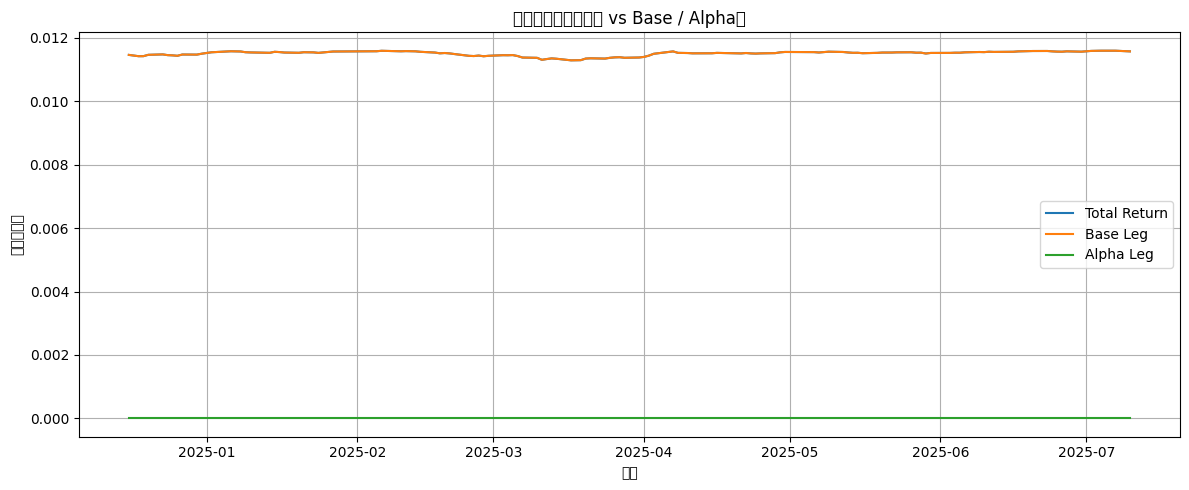

C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:39: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:39: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:39: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:39: UserWarning: Glyph 20363 (\N{CJK UNIFIED IDEOGRAPH-4F8B}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:39: UserWarning: Glyph 20489 (\N{CJK UNIFIED IDEOGRAPH-5009}) missing from current font.
  plt.tight_layout()
C:\Users\l\AppData\Local\Temp\ipykernel_18552\18813537.py:39: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from current font.
  plt.tight_l

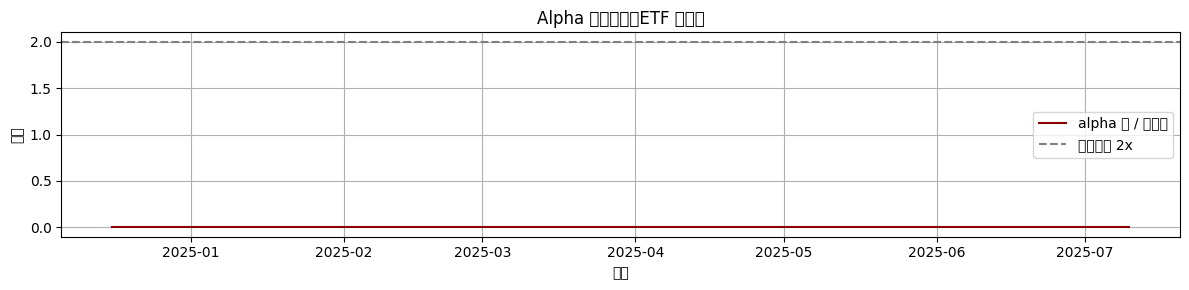

          date      equity  pnl_base  pnl_alpha  cum_return  alpha_etf  \
132 2025-07-04  10115972.0  115972.0        0.0    0.011597          0   
133 2025-07-07  10115973.0  115973.0        0.0    0.011597          0   
134 2025-07-08  10115909.0  115909.0        0.0    0.011591          0   
135 2025-07-09  10115879.0  115879.0        0.0    0.011588          0   
136 2025-07-10  10115765.0  115765.0        0.0    0.011577          0   

     alpha_fut  
132          0  
133          0  
134          0  
135          0  
136          0  
                                date       pnl_base  pnl_alpha  cum_return
count                            137     137.000000      137.0  137.000000
mean   2025-03-30 15:14:27.153284608  115082.948905        0.0    0.011508
min              2024-12-16 00:00:00  112938.000000        0.0    0.011294
25%              2025-02-11 00:00:00  114655.000000        0.0    0.011465
50%              2025-03-31 00:00:00  115315.000000        0.0    0.011532
75%

In [ ]:
import pandas as pd

# 读取合并后的数据
data =  pd.read_csv(r"C:\Users\l\OneDrive\桌面\东方财富\511520  hedging strategy\prediction\spread_lars_bayes_pred_win100_5d.csv", parse_dates=["date"]) 

# 调用回测函数
# （已集成）可視化模塊：收益拆解圖 + alpha 倉位佔比圖

result_df, pnl_df = backtest_spread_strategy(
    df =data,
    pred_col="lars_bayes_pred_5d",
    open_etf_col="open_etf",
    open_fut_col="open_fut",
    close_etf_col="close_etf",
    close_fut_col="close_fut",
    alpha_entry_threshold=-0.3  # ← 新增的控制参数
)

# 可视化收益 + alpha 仓位占比情况
plot_dual_leg_results(result_df, base_etf=1000)

# 查看关键回测数据
print(result_df.tail(5))
print(pnl_df.describe())


In [11]:
print(data[["date", "lars_bayes_pred_5d"]].tail(10))

          date  lars_bayes_pred_5d
127 2025-06-27            0.100260
128 2025-06-30            0.108639
129 2025-07-01            0.120203
130 2025-07-02            0.135838
131 2025-07-03            0.136650
132 2025-07-04                 NaN
133 2025-07-07                 NaN
134 2025-07-08                 NaN
135 2025-07-09                 NaN
136 2025-07-10                 NaN


In [ ]:
#new example usage

import pandas as pd

# 读取含有日期、开盘价、收盘价、预测列的数据
data = pd.read_csv(r"C:\Users\l\OneDrive\桌面\东方财富\511520  hedging strategy\prediction\spread_lars_bayes_pred_win100_5d.csv", parse_dates=["date"]) 

# 假设预测列为 lars_bayes_pred_5d 表示预测 5 日后的价差变化
result_df, metrics, realized_pnls = backtest_spread_strategy(
    df=data,
    pred_col="lars_bayes_pred_5d",
    open_etf_col="open_etf",
    open_fut_col="open_fut",
    close_etf_col="close_etf",
    close_fut_col="close_fut",
    initial_capital=10000000,
    margin_rate=0.1,
    tick_etf=0.001,
    tick_fut=0.005,
    etf_duration=7.5,
    conversion_factor=0.925,
    stop_gain=0.005,
    stop_loss=0.005
)

# 查看回测结果
print(metrics)
print(result_df.tail())

{'annual_return': 0.0, 'max_drawdown': 0.0, 'sharpe_ratio': 0.0, 'calmar_ratio': nan, 'win_rate': nan, 'total_trades': 0}
          date  position  trade    equity  cum_return  strategy_ret
132 2025-07-04         0      0  10000000         0.0           0.0
133 2025-07-07         0      0  10000000         0.0           0.0
134 2025-07-08         0      0  10000000         0.0           0.0
135 2025-07-09         0      0  10000000         0.0           0.0
136 2025-07-10         0      0  10000000         0.0           0.0


In [3]:
#示例：
data = pd.read_csv(r"C:\Users\l\OneDrive\桌面\东方财富\511520  hedging strategy\prediction\spread_lars_bayes_pred_win100_5d.csv", parse_dates=["date"]) 
# 假设已包含open/close和prediction列
result_df, metrics = backtest_spread_strategy(data, pred_col="lars_bayes_pred_5d", 
                                             open_etf_col="open_etf", open_fut_col="open_fut", 
                                             close_etf_col="close_etf", close_fut_col="close_fut", 
                                             initial_capital=10000000)
#查看回测结果后几天的记录和指标：
print(result_df[["date","position","trade","equity","cum_return"]].tail())
print(metrics)

年化收益率: 0.32%
最大回撤: 0.10%
Sharpe比: 1.20
Calmar比: 3.16
胜率: nan% (交易次数: 0)
          date  position  trade      equity  cum_return
132 2025-07-04         1      0  10015630.0    0.001563
133 2025-07-07         1      0  10017354.0    0.001735
134 2025-07-08         1      0  10016146.0    0.001615
135 2025-07-09         1      0  10020528.0    0.002053
136 2025-07-10         1      0  10017496.0    0.001750
{'annual_return': 0.0032206053380270383, 'max_drawdown': 0.0010186, 'sharpe_ratio': 1.1953681456131164, 'calmar_ratio': 3.161795933660945, 'win_rate': nan, 'total_trades': 0}


In [1]:
import matplotlib.pyplot as plt

def plot_backtest_performance(result_df, title="Strategy Backtest Equity Curve"):
    """
    Plot the backtest performance of a trading strategy.
    
    Parameters:
    -----------
    result_df : pd.DataFrame
        DataFrame containing backtest results with columns:
        - 'date' (datetime): Timestamps
        - 'cum_return' (float): Cumulative returns (0-based)
    title : str, optional
        Title for the plot (default: "Strategy Backtest Equity Curve")
    """
    plt.figure(figsize=(12, 6))
    
    # Plot equity curve
    plt.plot(result_df["date"], 
             result_df["cum_return"] + 1, 
             label="Strategy Equity",
             linewidth=2,
             color='steelblue')
    
    # Add reference line
    plt.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
    
    # Formatting
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Normalized Equity", fontsize=12)
    plt.title(title, fontsize=14, pad=20)
    plt.legend(fontsize=11, loc='upper left')
    
    # Grid and layout
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Show plot
    plt.show()

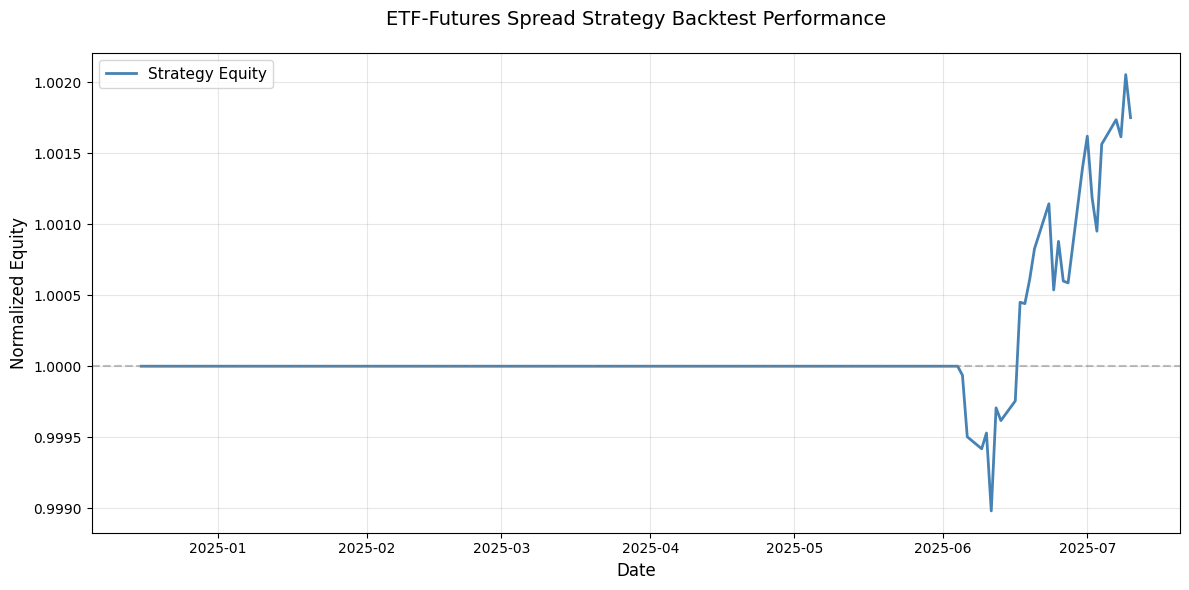

In [4]:
plot_backtest_performance(result_df, title="ETF-Futures Spread Strategy Backtest Performance")